# flexcv
## A Machine Learning and Method Comparison Framework with Nested CV
Use this example notebook to understand what you can use this repository for and how it can help you with you machine learning tasks.
##### We used it to
1. compare different models (methods),
2. given different sets of predictors
3. for different datasets
4. using both fixed and random effects as well as random slopes.
##### Furthermore it can help you to
1. perform nested cross validation: 
    - in the outer loop we evaluate cross validate model performance,
    - in the outer loop we select model parameters fairly without data leakage (inner cross validation) using a state-of-the-art optimization package,
3. customize objective functions for optimization to select meaningful model parameters,
4. scale inner and outer cross validation loops separately,
5. use different cross validation splits: dependant and independant of the clustering structures in your data,
6. use a state-of-the-art logging dashboard to track all of your experiments.
7. repeated runs

# ML Method Comparison Framework

This notebook provides an example of how to use the ML Method Comparison Framework to compare different machine learning models on different datasets with different sets of predictors. The framework supports both fixed and random effects, as well as random slopes.

## Example Usage

To use the framework, we will follow these steps in our example:

1. We will prepare randomly generated data for regression including a clustering hierarchy and random slopes.

## Features

The ML Method Comparison Framework provides the following features:

1. Cross validation of model performance using different cross validation splits that are dependent or independent of the clustering structures in your data.
2. Selection of model parameters fairly without data leakage using an inner cross validation loop and a state-of-the-art optimization package.
3. Customization of objective functions for optimization to select meaningful model parameters.
4. Scaling of inner and outer cross validation loops separately.
5. A state-of-the-art logging dashboard to track all of your experiments.

## Conclusion

The ML Method Comparison Framework is a powerful tool for comparing machine learning models on different datasets with different sets of predictors. It provides a range of features for cross validation, parameter selection, and experiment tracking.

If you really don't want to use Neptune for logging, you can use our DummyLogger instead and run the cell below.

# Generate the Data

For example purposes, let's generate some random data for regression. We will create the
1. X: a pandas DataFrame with all of our predictors
2. y: a pandas Series containing the target variable (continuous, since it's regression)
3. group: a Series with same number of rows as y and X indicating which person made the observation or to which semantic cluster the observation belongs. The groups Series will be used to create a random clustering structure in the data. 
4. Also, we use some of the X columns as random slopes.

The target variable is calculated as a linear combination of the predictors plus some noise.

$$ y = 1 + X \cdot \beta + \lambda \cdot \epsilon $$

With $\beta$ being a randomly generated vector of coefficients and $\epsilon$ being the noise drawn from a normal distribution with mean 0 and standard deviation 1. $\lambda$ is a factor that can be changed by the user to adjust the noise level.


You can use this LaTeX code to render the equations in your LaTeX document.

Then, we write a test function, that returns the fixed effects R² of our regression data. This can be handy to force a specific R² value to the data.

In [1]:
import numpy as np
import pandas as pd


def select_random_columns(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Select n random columns from a pandas DataFrame and return a new DataFrame containing only these columns.
    :param df: input DataFrame
    :param n: number of columns to select
    :return: DataFrame containing n randomly selected columns
    """
    column_names = df.columns.tolist()
    random_column_names = np.random.choice(column_names, size=n, replace=False)
    return df[random_column_names]


def generate_regression(m_features: int, n_samples: int, n_groups: int = 100, n_slopes = 1, noise = 0.1):
    """
    Generate a dataset for linear regression using the numpy default rng.
    :param m_features: number of features
    :param n_samples: number of samples
    :param n_groups: number of groups
    :param n_slopes: number of slopes
    :param noise: noise level
    :return: dataset
    """
    FIXED_LEVEL = 0.01
    RANDOM_LEVEL = 1

    # initialize random number generator and generate predictors randomly 
    rng = np.random.default_rng(42)
    X = rng.integers(-10, 10, (n_samples, m_features))

    # generate random coefficients with a linear relationship and add noise
    beta_fixed = rng.random(m_features) * FIXED_LEVEL
    epsilon = rng.standard_normal(n_samples) * noise
    # y = 1 + X @ beta + epsilon

    # generate random group labels
    group = rng.integers(0, n_groups, n_samples)

    # generate random effects -> linear relationships for each group
    beta_random = rng.uniform(0.9, 1.0, size=n_groups) * RANDOM_LEVEL
    # reorder the random effects betas according to the group labels
    random_effects = beta_random[group]

    # generate the response variable
    y = 1 + X @ beta_fixed + random_effects + epsilon

    # convert to pandas dataframe with random column names
    X = pd.DataFrame(X, columns=[f"X{i}" for i in range(X.shape[1])])
    y = pd.Series(y, name="y")
    group = pd.Series(group, name="group")

    # select a random column to be the random slope
    random_slopes = select_random_columns(X, n_slopes)
    return X, y, group, random_slopes

With this function we can generate our data set.

In [2]:
X, y, group, random_slopes = generate_regression(10, 1000, n_slopes=1, noise=0.096)

Alternatively, feel free to import your own data set like this.
```python
    df = pd.read_csv("your_data.csv")
    X = df.drop(columns=["y"])
    y = df["y"]
    group = df["group"]
    random_slopes = X["a_column_of_choice"]
```

X DataFrame.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X0      1000 non-null   int64
 1   X1      1000 non-null   int64
 2   X2      1000 non-null   int64
 3   X3      1000 non-null   int64
 4   X4      1000 non-null   int64
 5   X5      1000 non-null   int64
 6   X6      1000 non-null   int64
 7   X7      1000 non-null   int64
 8   X8      1000 non-null   int64
 9   X9      1000 non-null   int64
dtypes: int64(10)
memory usage: 78.2 KB
None

Y Series Description.
count    1000.000000
mean        1.926191
std         0.142295
min         1.453501
25%         1.832760
50%         1.922994
75%         2.020629
max         2.408882
Name: y, dtype: float64

Group Series Description
count    1000.000000
mean       47.590000
std        29.064491
min         0.000000
25%        22.000000
50%        46.000000
75%        73.000000
max        99.000000
Name: g

<Axes: >

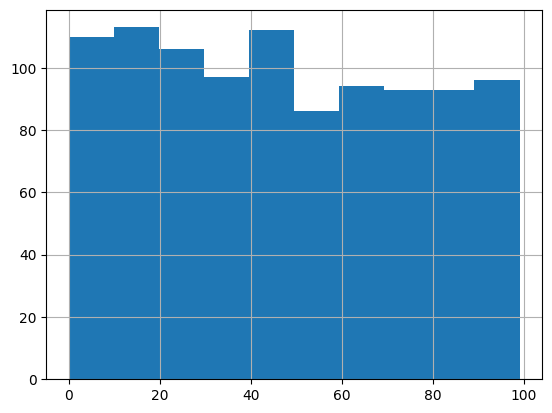

In [3]:
# show some basic info about the 
print("X DataFrame.")
print(X.info(), end="\n\n")
print("Y Series Description.")
print(y.describe(), end="\n\n")
print("Group Series Description")
print(group.describe(), end="\n\n")
print("Random Slope Info")
print(random_slopes.info(), end="\n\n")

group.hist()

Let's import some classes and functions we will work with in the next steps:

In [4]:
from typing import Dict
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
import optuna
from flexcv.merf_adaptation import MERF
from flexcv.models import LinearModel
from flexcv.models import LinearMixedEffectsModel
import flexcv.model_postprocessing as mp

from flexcv.cross_val import cross_validate
from flexcv.run import RunConfigurator
from flexcv.data_loader import DataLoadConfig
from flexcv.cross_val_split import CrossValMethod
from flexcv.run import Run
dummy_run = Run()

One thing our framework allows you to do, is to use different cross validation splits. You can choose between splits that are dependent or independent of the clustering structures in your data. We use the CrossValMethod class to define the cross validation method we want to use. This class is an Enum with the following options:

In [5]:
pprint(CrossValMethod._member_map_)

{'CUSTOM': <CrossValMethod.CUSTOM: 'CustomStratifiedGroupKFold'>,
 'GROUPKFOLD': <CrossValMethod.GROUPKFOLD: 'GroupKFold'>,
 'KFOLD': <CrossValMethod.KFOLD: 'KFold'>,
 'STRAT': <CrossValMethod.STRAT: 'CustomStratifiedKFold'>,
 'STRATGROUPKFOLD': <CrossValMethod.STRATGROUPKFOLD: 'StratifiedGroupKFold'>}


This Enum class is used to map the cross validation method to a string and make it easier to use in the framework.
The most basic split can be obtained with KFOLD. This will split the data into k folds and use one fold for testing and the remaining folds for training. The folds are created randomly and are independent of the clustering structure in the data.
If you want to make sure that the distribution of your target variable in the folds is similar to the distribution of the target variable in the whole dataset, you can use STRAT. This will create folds that are similar to the whole dataset in terms of the distribution of the target variable (stratification). The folds are created randomly and are independent of the clustering structure in the data.
Next you have the possibility to add dependency to the clustering structure in your data. This can be done with the methods GROUPKFOLD, STRATGROUPKFOLD and CUSTOM. The folds are created randomly and are dependent of the clustering structure in the data in terms of the scikit-learn logic, where groups will not appear in training as well as testing folds and will not be split and the number of groups per fold is approximately the same. Now, you can also use stratification to make sure that the distribution of your target variable in the folds is similar to the distribution of the target variable in the whole dataset. This can be done with the methods STRATGROUPKFOLD and CUSTOM. 

Then, you need to know our paper-related convention of using the model_level variable. If set to 4, random effects are modelled. If set to 3, only fixed effects are modelled. This is useful for comparing different models with different random effects structures.

We control how runs are initiated and conducted with our RunConfigurator class from our run module.
Also, we use an instance of the class DataLoadConfig to hold our dataset-related info of the run.
Let's create an instance of the class RunConfigurator. We will use it to initiate and conduct our runs.
The dataset name is used for logging purposes. Also, some of the model parameters could be made dataset-specific.
With the model_level attribute we can control, how the random effects are modelled. In line with our paper published, we use an integer enumeration of model_level. This makes it easy to compare different sets of predictors. If set to 4, which is the highest level in the paper, random effects are modelled. If set to 3, only fixed effects are modelled. This is useful for comparing different models with different random effects structures.
For convenience, you can just use the str "fixed_only" or "mixed" instead of the integer enumeration. Then, "fixed_only" we internally set to model_level 3 and "mixed" to model_level 4.

In [6]:

data_load_config = DataLoadConfig(
    dataset_name="random_example",  # choose arbitrary name
    model_level="fixed_only",  # use: "fixed_only", "mixed"
    target_name=y.name,
    slopes=random_slopes.columns.tolist(),  # list of column names; does not need to be specified for fixed_only
)

run_config = RunConfigurator(
    data_load_config,
    cross_val_method=CrossValMethod.KFOLD,
    cross_val_method_in=CrossValMethod.KFOLD,
    n_splits=3,
    n_trials=3,
    run=dummy_run
)

Now we want to set up some models to be fit to and evaluated on our data.
We can configure different models at once by using a model_mapping dictionary. We will use it to create our models in the next step.
It maps the model names to the model classes which are instantited during fit and evaluation.
Our model mapping dictionary is used for the following purposes:
1. to create the models in the cross_validate function by iterating over the dictionary keys,
2. to control specific parameters in the cross_validate function that will determine how the procedure is conducted for each model (e.g. n_jobs: Some models behave differently when n_jobs is set to 1 or -1. This can be important when using model types that are instantiated using rpy2 under the hood. We use rpy2 for the EARTH estimator.),
3. to determine whether inner cross validation is necessary. For example, a simple linear model can not be tuned in inner CV, therefore, we set the inner_cv parameter to False for the LinearRegression model. This will skip the inner CV loop for this model.
4. to provide a distribution of model parameters. The optimization algorithm will choose from this distributions in the inner CV.

In [13]:

model_mapping: Dict[str, Dict] = {
    "LinearModel": {
        "inner_cv": False,
        "n_trials": 3,
        "n_jobs_model": {"n_jobs": 1},
        "n_jobs_cv": 1,
        "model": LinearModel,
        "params": {},
        "post_processor": mp.lm_post,
        "mixed_model": LinearMixedEffectsModel,
        "mixed_post_processor": mp.lmer_post,
        "mixed_name": "MixedLM"
    },

    "RandomForest": {
        "inner_cv": True,
        "n_trials": 3,
        "n_jobs_model": {"n_jobs": -1},
        "n_jobs_cv": -1,
        "model": RandomForestRegressor,
        "params": {
            "max_depth": optuna.distributions.IntDistribution(5, 15), 
        },
        "post_processor": lambda *args, **kwargs: None,
        "mixed_model": MERF,
        "mixed_post_processor": lambda *args, **kwargs: None,
        "mixed_name": "MERF",
    },
}

Now we are ready to pass everything to our custom cross_validate function. It will conduct the cross validation and log the results to Neptune or to our Dummy run object.


In [14]:
from flexcv.cross_val import cross_validate as cv



results = cv(
    RunConfiguration=run_config,
    X=X,
    y=y,
    run=dummy_run,
    group=group,
    slopes=random_slopes,
    mapping=model_mapping,
)

No Neptune run object passed. Logging to Neptune will be disabled.


 cv:   0%|          | 0/3 [00:00<?, ?it/s]

[I 2023-10-13 17:31:14,078] A new study created in memory with name: no-name-83a49dd2-5875-4fec-982f-45229b5593cd
[I 2023-10-13 17:31:21,910] Trial 0 finished with value: -0.012279295467611978 and parameters: {'model__max_depth': 10}. Best is trial 0 with value: -0.012279295467611978.
[I 2023-10-13 17:31:29,888] Trial 1 finished with value: -0.012217374156329003 and parameters: {'model__max_depth': 14}. Best is trial 1 with value: -0.012217374156329003.
[I 2023-10-13 17:31:38,117] Trial 2 finished with value: -0.01284964372469631 and parameters: {'model__max_depth': 5}. Best is trial 1 with value: -0.012217374156329003.
 cv:  33%|███▎      | 1/3 [00:25<00:51, 25.59s/it]

[I 2023-10-13 17:31:39,630] A new study created in memory with name: no-name-54dfab84-3874-48ae-b030-595af6ee277d
[I 2023-10-13 17:31:47,558] Trial 0 finished with value: -0.012340737436364222 and parameters: {'model__max_depth': 10}. Best is trial 0 with value: -0.012340737436364222.
[I 2023-10-13 17:31:55,529] Trial 1 finished with value: -0.012338906568062096 and parameters: {'model__max_depth': 14}. Best is trial 1 with value: -0.012338906568062096.
[I 2023-10-13 17:32:03,595] Trial 2 finished with value: -0.012558664819044843 and parameters: {'model__max_depth': 5}. Best is trial 1 with value: -0.012338906568062096.
 cv:  67%|██████▋   | 2/3 [00:51<00:25, 25.52s/it]

[I 2023-10-13 17:32:05,022] A new study created in memory with name: no-name-425160bd-d7d6-4b6a-ad18-9a100aa86b69
[I 2023-10-13 17:32:13,078] Trial 0 finished with value: -0.013274169204275344 and parameters: {'model__max_depth': 10}. Best is trial 0 with value: -0.013274169204275344.
[I 2023-10-13 17:32:21,052] Trial 1 finished with value: -0.01328609671204859 and parameters: {'model__max_depth': 14}. Best is trial 0 with value: -0.013274169204275344.
[I 2023-10-13 17:32:29,023] Trial 2 finished with value: -0.013618672761191018 and parameters: {'model__max_depth': 5}. Best is trial 0 with value: -0.013274169204275344.
                                                  

In [50]:
for key, value in results.items():
    print(f"""{key}:
    Test Performance:
    R² per Fold: {value['results']['r2']} Mean R²: {np.mean(value['results']['r2']):.3f}
    MSE in Training:
    MSE per Fold: {value['results']['mse_train']} Mean MSE: {np.mean(value['results']['mse_train']):.3f}
    MSE in Test:
    MSE per Fold: {value['results']['mse']} Mean MSE: {np.mean(value['results']['mse']):.3f}
    \n
    """)


LinearModel:
    Test Performance:
    R² per Fold: [0.5001471722774329, 0.4428348736973795, 0.5662113835268121, 0.544414529894409, 0.4771107847618129] Mean R²: 0.506
    MSE in Training:
    MSE per Fold: [0.009233842447746303, 0.008962565104658076, 0.009562860850629237, 0.009068444327763995, 0.008949417737302932] Mean MSE: 0.009
    MSE in Test:
    MSE per Fold: [0.009109537298773058, 0.0102188709459474, 0.007831051136590442, 0.009672573153155612, 0.0103238508384143] Mean MSE: 0.009
    

    
MixedLM:
    Test Performance:
    R² per Fold: [0.5025151107145351, 0.44872437532912934, 0.5656435722211428, 0.5431896496072073, 0.47689134351924334] Mean R²: 0.507
    MSE in Training:
    MSE per Fold: [0.009246331831114658, 0.008978093643965101, 0.00958172794994147, 0.00907908331799589, 0.008950531681055064] Mean MSE: 0.009
    MSE in Test:
    MSE per Fold: [0.009066382949497367, 0.010110852596862662, 0.007841301657700892, 0.009698578688799824, 0.010328183455324467] Mean MSE: 0.009
    



Great, our linear model is able to approximately reproduce the fixed effects R² of our data. The basic Random Forest Regressor is not well tuned and therefore performs poorly at the moment. Feel free to play around with the parameters of the Random Forest Regressor and especially increase the n_trials parameter to allow for a longer parameter optimization process and see how it affects the results.

In the next part, we want to also incorporate Random Effects into our model. Therefore, we have to change model_level in our DataLoadConfig instance to "mixed". This will allow the cross_validate function to fit models with random effects. The corss_validate function will first model the data with the fixed effects only model, and then builds a new model with random effects. So you always have fixed and random effects side by side in the results.

In [32]:
model_map: Dict[str, Dict] = {
    "LinearModel": {
        "inner_cv": False,
        "n_trials": 100,
        "n_jobs_model": {"n_jobs": 1},
        "n_jobs_cv": 1,
        "model": LinearModel,
        "params": {},
        "post_processor": mp.lm_post,
        "mixed_model": LinearMixedEffectsModel,
        "mixed_post_processor": mp.lmer_post,
        "mixed_name": "MixedLM"
    },
}


In [33]:

run_config = RunConfigurator(
    data_load_config,
    cross_val_method=CrossValMethod.CUSTOM,
    cross_val_method_in=CrossValMethod.CUSTOM,
    n_splits=5,
    n_trials=10,
    em_stopping_window=10,
    run=dummy_run
)
results = cross_validate(
    RunConfiguration=run_config,
    X=X,
    y=y,
    run=dummy_run,
    group=group,
    slopes=random_slopes,
    mapping=model_map
)

for key, value in results.items():
    print(f"{key}:\nR² per Fold: {value['results']['r2']} Mean R²: {np.mean(value['results']['r2']):.3f}")

No Neptune run object passed. Logging to Neptune will be disabled.


 cv:   0%|          | 0/5 [00:00<?, ?it/s]

 cv:  20%|██        | 1/5 [00:05<00:23,  5.88s/it]

 cv:  40%|████      | 2/5 [00:11<00:17,  5.70s/it]

 cv:  60%|██████    | 3/5 [00:16<00:11,  5.61s/it]

 cv:  80%|████████  | 4/5 [00:22<00:05,  5.58s/it]



LinearModel:
R² per Fold: [0.5001471722774329, 0.4428348736973795, 0.5662113835268121, 0.544414529894409, 0.4771107847618129] Mean R²: 0.506
MixedLM:
R² per Fold: [0.5025151107145351, 0.44872437532912934, 0.5656435722211428, 0.5431896496072073, 0.47689134351924334] Mean R²: 0.507


Let's inspect the structure of the results object. It is a nested dictionary, which means that some of the values are dictionaries themselves. The outer dictionary has the model names as keys. The inner dictionaries contain model objects, their parameters or summaries, a separate results dictionary containing only metrics. Also, we find lists of the predictions and the true values (testing and training) for each fold of the cross validation.
Results is constructed like this:
```python
    results: Dict[str, Dict[str, list | dict]] = {
        model_name: {
            "model": [],
            "parameters": [],
            "metrics": {},
            "y_pred": [],
            "y_test": [],
            "shap_values": [],
        }
        for model_name in model_keys
    }
```
With the following function we can quickly get an overview of the results.

In [65]:
def pprint_dict(d, indent=""):
    """
    Pretty-print a dictionary, only printing values that are themselves dictionaries.
    :param d: dictionary to print
    """
    for key, value in d.items():
        print(f"{indent}{key}")
        if isinstance(value, dict):
            pprint_dict(value, indent + "  ")

pprint_dict(results)

LinearModel
  model
  parameters
  results
    r2
    r2_train
    mse
    mse_train
    mse_in_test
    mse_in_train
    mae
    mae_train
    rmse
    rmse_train
  r2
  r2_train
  y_pred
  y_test
  shap_values
  median_index
MixedLM
  model
  parameters
  results
    r2
    r2_train
    mse
    mse_train
    mse_in_test
    mse_in_train
    mae
    mae_train
    rmse
    rmse_train
  r2
  r2_train
  y_pred
  y_test
  shap_values
  median_index


In [18]:

run_config = RunConfigurator(
    data_load_config,
    cross_val_method=CrossValMethod.KFOLD,
    cross_val_method_in=CrossValMethod.KFOLD,
    n_splits=5,
    n_trials=10,
    em_stopping_window=10,
    run=dummy_run
)
results = cross_validate(
    RunConfiguration=run_config,
    X=X,
    y=y,
    run=dummy_run,
    group=group,
    slopes=random_slopes,
    mapping=model_map
)

for key, value in results.items():
    print(f"{key}:\nR² per Fold: {value['results']['r2']} Mean R²: {np.mean(value['results']['r2']):.3f}")
    # TODO show other metrics

No Neptune run object passed. Logging to Neptune will be disabled.


 cv:   0%|          | 0/5 [00:00<?, ?it/s]

 cv:  20%|██        | 1/5 [00:08<00:32,  8.10s/it]

 cv:  40%|████      | 2/5 [00:16<00:25,  8.55s/it]

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 cv:  60%|██████    | 3/5 [00:25<00:16,  8.33s/it]More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
 cv:  80%|████████  | 4/5 [00:39<00:10, 10.92s/it]



LinearModel:
R² per Fold: [0.46691057493789, 0.5227469970953811, 0.4934364268372097, 0.4435647719203011, 0.5219123305294142] Mean R²: 0.490
MixedLM:
R² per Fold: [0.4668807469467139, 0.5225661018398995, 0.49084686987324067, 0.4437517006171371, 0.5219145992976639] Mean R²: 0.489


# Repeated Runs
What we have done so far was using nested cross validation for a single time. In our program, there are some processes that make use of randomization. For example, the random forest regressor uses randomization to build the trees. Also the data is split into train and test folds utilizing a random seed. Therefore, we can not be sure that the results we get are not just a result of the randomization. To make sure that our results are not just a result of the randomization, we can repeat the cross validation process multiple times. Let's see how repeated runs can be easily obtained with our framework.
In the following implementation, we construct a set of random runs each using a different seed. The set however is also reproducable since we are seeding the random number generator before creating the runs. This way, we can even reproduce the results of the repeated runs exactly.

In [ ]:

n_repeats = 3

dataset = "repeated_example"

run_config = RunConfigurator(
    data_load_config,
    cross_val_method=CrossValMethod.CUSTOM,
    cross_val_method_in=CrossValMethod.CUSTOM,
    n_splits=5,
    n_trials=10,
    em_stopping_window=10,
    run=dummy_run
)

repeated_run = dummy_run()  # neptune.init_run(**your_credentials)
repeated_id = repeated_run["sys/id"].fetch()
desc = f"Instance of repeated run {repeated_id}."

# set numpy seed to 42. 
# If you do not want to reproduce the repeated run, change the seed or remove the line
np.random.seed(42)

# generate a list of random seeds to use in the repeated loop
# the random seeds are used to generate the random folds in the repeated loop
seeds = np.random.randint(42000, size=n_repeats).tolist()

run_ids = []
run_metrics = []
for seed in seeds:
    # create a new run for each repeat
    # neptune will log every inner run as well as the host run
    inner_run = dummy_run()  # neptune.init_run(**your_credentials)
    inner_id = inner_run["sys/id"].fetch()
    inner_run["HostRun"] = repeated_id
    inner_run["seed"] = seed

    # call cross_validate on the random seed
    run_metric = cross_validate(
        RunConfiguration=run_config,
        X=X,
        y=y,
        run=dummy_run,
        group=group,
        slopes=random_slopes,
        mapping=model_map,
        random_seed=seed,  # this line is crucial in the repeated loop
    )

    # append the run id and the run metric to the lists
    run_ids.append(inner_id)
    run_metrics.append(run_metric)

from run_repeated_cv import aggregate_

df = aggregate_(run_metrics)
df.to_excel("repeated_cv.xlsx")  # save dataframe to excel file
print(df)  # print dataframe to console

from neptune import File
# log the repeated run results to neptune
repeated_id = repeated_run["sys/id"].fetch()
repeated_run["summary"].upload(File.as_html(df))
repeated_run["sys/description"] = f"Host run for repeated runs with {n_repeats} repeats. run_ids: {run_ids}"
repeated_run["RelatedRuns"] = ", ".join(run_ids)
repeated_run["seeds"] = seeds
repeated_run["mapping"] = model_map
repeated_run.stop()

In a follow up step, we can now use a custom aggregation function to aggregate the results of the repeated runs. For example, we can calculate the mean and standard deviation of the metrics over the repeated runs.

# Adding Evaluation Metrics
If you use cross_validate without the metrics keyword argument, the function uses the following mapping by default:

```python
METRICS = {
    "r2": r2_score,
    "mse": mean_squared_error,
    "mae": mean_absolute_error,
    "rmse": rmse_score,
}
```
In this dictionary, the keys are the names of the metrics and the values are the functions that calculate the metrics. You can add your own metrics to this dictionary or overwrite the existing ones. The function will then calculate the metrics and add them to the results dictionary. Per default the scoring functions are imported from the sklearn.metrics module. You can also use your own functions. Just make sure that they have the same signature as the functions in the METRICS dictionary (y_true, y_pred).

In [ ]:
# Example on how to add an evaluation metric to the cross_validate function
# get machine precison
EPS = np.finfo(np.float64).eps
metrics = {
    "res_below_threshold": lambda y_true, y_pred: int(np.abs(y_true - y_pred) < EPS)  # this metric is 1 if the residual is below machine precision and 0 otherwise
}

results = cross_validate(
    RunConfiguration=run_config,
    X=X,
    y=y,
    run=dummy_run,
    group=group,
    slopes=random_slopes,
    mapping=model_map,
    metrics=metrics
)

# Changing the objective scorer function
In the nner cross validation the optuna package uses a Bayesian sampler to sample a set of parameters from the parameter space (defined by the parameter distributions). The objective function is used to evaluate the performance of the model with the specific set of parameters. Each set of parameters is cross validated using a scorer method which is used as the objective function that is to be maximized. Per default, the scorer function is the mean squared error. You can change the scorer function by passing a different function to the scorer keyword argument of the cross_validate function. The function will then be used as the objective function in the inner cross validation loop.
For example you can import this custom function, that incorporates also overfitting and underfitting in the inner folds:
```python
def objective_scorer(MSE_valid, MSE_train):
    """Objective scorer for the hyperparameter optimization."""

    MSE_delta = MSE_train - MSE_valid
    weight_MSE_delta = 0.5
    target_delta = .05
        
        #MSE_valid + weight_MSE_delta * abs(MSE_delta)
    return (1 * MSE_valid + 
            0.5 * abs(MSE_delta) + 
            2 * max(0, (MSE_delta - target_delta)) + 
            1 * max(0, -MSE_delta)
            )
```


The following cell shows how to use the custom objective scorer function in the cross_validate function.

In [2]:
from flexcv.scorer import custom_scorer
from sklearn.metrics import mean_squared_error

def mse_wrapper(y_valid, y_pred, y_train_in, y_pred_train):
    return mean_squared_error(y_valid, y_pred)

results = cross_validate(
    RunConfiguration=run_config,
    X=X,
    y=y,
    run=dummy_run,
    group=group,
    slopes=random_slopes,
    mapping=model_map,
    scorer=custom_scorer  # 
)

Wrapper for Earth using rpy2
Adaptation of statsmodels classes with random slopes



In [ ]:
from flexcv.cross_val import DataLoadConfigurator
from flexcv.cross_val import CVData
from flexcv.cross_val import CrossValConfigurator
from flexcv.cross_val import MixedEffectsConfigurator
from flexcv.cross_val import RunConfigurator
from flexcv.cross_val import OptimizationConfigurator
from flexcv.cross_val import CrossValidation
from flexcv.cross_val import perform


data_config = DataLoadConfigurator(
    dataset_name="random_example",
    model_level="fixed_only",
    target_name=y.name,
    slopes=random_slopes.columns.tolist(),
)

cv_config = CrossValConfigurator(
    cross_val_method=CrossValMethod.KFOLD,
    cross_val_method_in=CrossValMethod.KFOLD,
    n_splits=5,
    scale_in=True,
    scale_out=True,
    break_cross_val=False,
    # metrics={...} would allow to pass a dict of custom metrics
)

mixed_config = MixedEffectsConfigurator(
    em_max_iterations=50,
    em_stopping_window=10,
    em_tolerance=1e-6,
)

run_config = RunConfigurator(
    run=dummy_run
)

opt_config = OptimizationConfigurator(
    optuna=True,
    n_trials=10,
)

cv_data = CVData(
    X=X,
    y=y,
    group=group,
    slopes=random_slopes,
)

cv = CrossValidation(
    DataLoadConfiguration=data_config,
    CrossValConfiguration=cv_config,
    MixedEffectsConfiguration=mixed_config,
    RunConfiguration=run_config,
    OptimizationConfiguration=opt_config,
    model_mapping=model_map,
    CVData=cv_data,
)

for seed in [42, 43, 44]:
    cv.random_seed = seed
    results = perform(cv)
    print(results)